<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/notebooks/tune_hyper_parameters_unsup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot model_complexity Vs training and validation loss

In [1]:
%tensorflow_version 1.14.0
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Mounted at /content/gdrive
/content/gdrive/MyDrive/concept_learning/concept_learning


In [12]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns

from clearn.config import ExperimentConfig
from clearn.analysis.plot_metrics import plot_z_dim_vs_accuracy, plot_epoch_vs_metric

In [3]:
from typing import List
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from clearn.config import ExperimentConfig
from clearn.dao.dao_factory import get_dao
from clearn.utils.dir_utils import get_eval_result_dir


def plot_z_dim_vs_accuracy(root_path: str,
                           experiment_name: str,
                           z_dim_range: List,
                           num_units: List,
                           num_cluster_config: str,
                           num_epochs: int,
                           run_id: int,
                           split_name: str,
                           num_val_samples: int,
                           activation_output_layer="SIGMOID",
                           dataset_name="mnist",
                           batch_size=64,
                           num_decoder_layer=4,
                           metric="accuracy",
                           cumulative_function=np.max
                           ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    training_accuracies = []
    z_dims = []
    validation_accuracies = []
    for z_dim in z_dim_range:
        exp_config = ExperimentConfig(root_path=root_path,
                                      num_decoder_layer=num_decoder_layer,
                                      z_dim=z_dim,
                                      num_units=num_units,
                                      num_cluster_config=num_cluster_config,
                                      confidence_decay_factor=5,
                                      beta=5,
                                      supervise_weight=1,
                                      dataset_name=dataset_name,
                                      split_name=split_name,
                                      model_name="VAE",
                                      batch_size=batch_size,
                                      name=experiment_name,
                                      num_val_samples=num_val_samples,
                                      total_training_samples=dao.number_of_training_samples,
                                      manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                      reconstruction_weight=1,
                                      activation_hidden_layer="RELU",
                                      activation_output_layer=activation_output_layer
                                      )
        exp_config.check_and_create_directories(run_id, False)
        file_prefix = f"/train_{metric}_*.csv"
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        if df is not None:
          _train_accuracies = df[metric].values
        else:
          # Try older version of accuracy file
          file_prefix = f"/{metric}_*.csv"
          df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
          if df is not None:
            if f"train_{metric}_mean" in df.columns:
              _train_accuracies = df[f"train_{metric}_mean"].values
              _val_accuracies = df[f"val_{metric}_mean"].values
            else:
              _train_accuracies = df[f"train_{metric}"].values
              _val_accuracies = df[f"val_{metric}"].values

          else:
            raise Exception(f"File does not exist {exp_config.ANALYSIS_PATH + file_prefix}")
        max_accuracy = cumulative_function(_train_accuracies)
        #max_index = np.argmax(_train_accuracies)
        training_accuracies.append(max_accuracy)

        exp_config.check_and_create_directories(run_id)

        file_prefix = f"/val_{metric}_*.csv"
        
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        if df is not None:
          _val_accuracies = df[metric].values
        else:
          # Try older version of accuracy file
          file_prefix = f"/{metric}_*.csv"
          df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
          if df is not None:
            if f"val_{metric}_mean" in df.columns:
              _val_accuracies = df[f"val_{metric}_mean"].values
            else:
              _val_accuracies = df[f"val_{metric}"].values
          else:
            raise Exception(f"File does not exist {exp_config.ANALYSIS_PATH + file_prefix}")
        max_accuracy = cumulative_function(_val_accuracies)
        #max_index = np.argmax(_val_accuracies)
        validation_accuracies.append(max_accuracy)

        z_dims.append(z_dim)

    plt.plot(z_dims, training_accuracies)
    plt.plot(z_dims, validation_accuracies)
    plt.legend(["train", "Validation"])
    plt.xlabel("z_dim")
    plt.ylabel(metric.capitalize())
    plt.title(f"Num units {num_units} Training epochs {num_epochs}")

def read_accuracy_from_file(file_prefix):
    df = None
    print(file_prefix)
    for file in glob.glob(file_prefix):
        print(file_prefix, file)
        temp_df = pd.read_csv(file)
        if df is None:
            df = temp_df
        else:
            pd.concat([df, temp_df], axis=1)
    return df


def plot_epoch_vs_metric(root_path: str,
                         experiment_name: str,
                         num_units: List[int],
                         num_cluster_config: str,
                         z_dim: int,
                         run_id: int,
                         dataset_types: List[str]=["train", "test"],
                         activation_output_layer="SIGMOID",
                         dataset_name="mnist",
                         split_name="Split_1",
                         batch_size=64,
                         num_val_samples=128,
                         num_decoder_layer=4,
                         metrics: List[str]=["accuracy"],
                         legend_loc="best",
                         show_sample_images=True
                         ):
    colors = ['r', 'g', 'b', 'y']
    dao = get_dao(dataset_name, split_name, num_val_samples)
    exp_config = ExperimentConfig(root_path=root_path,
                                  num_decoder_layer=num_decoder_layer,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  activation_output_layer=activation_output_layer
                                  )
    exp_config.check_and_create_directories(run_id, False)
    file_prefix = "/metrics_*.csv"
    df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
    ax = [None] * len(metrics)
    plots = [None] * (len(metrics) * len(dataset_types))
    plot_number = 0
    fig = plt.figure(figsize=[20,10])
    for i, metric in enumerate(metrics):
        if i == 0:
            main_axis = plt.subplot(1, 2, 1)
            ax[i] = main_axis
        else:
            ax[i] = main_axis.twinx()

        for dataset_type in dataset_types:
            plots[plot_number], = ax[i].plot(df["epoch"],
                                             df[f"{dataset_type}_{metric}"],
                                             colors[plot_number],
                                             label=f"{dataset_type}_{metric}")
            plot_number += 1
        plt.ylabel(metric.title())
        plt.xlabel("Epochs")
    if show_sample_images:
      im_ax = plt.subplot(1,2,2)
      _num_epochs_trained = df["epoch"].max()
      _num_batches_train = dao.number_of_training_samples // exp_config.BATCH_SIZE

      reconstructed_dir = get_eval_result_dir(exp_config.PREDICTION_RESULTS_PATH,
                                              _num_epochs_trained,
                                              _num_batches_train)
      print(reconstructed_dir)
      sample_image = cv2.imread(reconstructed_dir + "/im_0.png")
      im_ax.imshow( sample_image )

    main_axis.legend(handles=plots,
                     labels=[l.get_label() for l in plots],
                     loc=legend_loc,
                     shadow=True,
                     fontsize='x-large')
    plt.suptitle(f"Number of units {num_units} z_dim = {z_dim}")
    plt.grid()



def plot_accuracy_multiple_runs(root_path: str,
                                experiment_name: str,
                                num_units: List[int],
                                run_ids: List[int],
                                num_cluster_config: str,
                                z_dim: int,
                                activation_output_layer="SIGMOID",
                                dataset_name="mnist",
                                split_name="Split_1",
                                batch_size=64,
                                num_val_samples=128,
                                num_decoder_layer=4
                                ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    plt.figure()
    dataset_name = "test"
    plt.xlabel("Run_ID")
    plt.ylabel("Max Accuracy")
    accuracies = []
    num_epochs_trained = -1
    for run_id in run_ids:
        exp_config = ExperimentConfig(root_path=root_path,
                                      num_decoder_layer=num_decoder_layer,
                                      z_dim=z_dim,
                                      num_units=num_units,
                                      num_cluster_config=num_cluster_config,
                                      confidence_decay_factor=5,
                                      beta=5,
                                      supervise_weight=1,
                                      dataset_name=dataset_name,
                                      split_name=split_name,
                                      model_name="VAE",
                                      batch_size=batch_size,
                                      name=experiment_name,
                                      num_val_samples=num_val_samples,
                                      total_training_samples=dao.number_of_training_samples,
                                      manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                      reconstruction_weight=1,
                                      activation_hidden_layer="RELU",
                                      activation_output_layer=activation_output_layer
                                      )
        exp_config.check_and_create_directories(run_id, False)

        file_prefix = "/accuracy_*.csv"
        df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
        print(df.shape, df[f"{dataset_name}_accuracy"].max())
        accuracies.append(df[f"{dataset_name}_accuracy"].max())

        _num_epochs_trained = df["epoch"].max() + 1
        if num_epochs_trained == -1:
            num_epochs_trained = _num_epochs_trained
        else:
            if _num_epochs_trained != num_epochs_trained:
                print(f"Number of epochs for {run_id} is {_num_epochs_trained}")

    plt.plot(accuracies)

    return accuracies


# Experiment Parameters

In [4]:
create_split = False
experiment_name = "find_architecture_unsup"
num_val_samples = -1
split_name ="Split_70_30"
reconstruction_weight = 1
dataset_name="mnist"
batch_size=128
z_dim_range = range(5, 30, 2)

num_epochs = 50
num_cluster_config = None
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"
run_id = 1
metric="reconstruction_loss"
num_units_list = [[64, 32],
                  [32, 32],
                  [16, 32],
                  [8, 32],
                  [4, 32],
                  [2, 32],
                      ]
num_unit_index = -1
batch_size = 128


In [5]:
from typing import List
from clearn.dao.dao_factory import get_dao
from clearn.analysis.plot_metrics import read_accuracy_from_file
def plot_epoch_vs_accuracy(root_path: str,
                           experiment_name: str,
                           num_units: List[int],
                           num_cluster_config: str,
                           z_dim: int,
                           run_id: int,
                           dataset_types: List[str] = ["train", "test"],
                           activation_output_layer="SIGMOID",
                           dataset_name="mnist",
                           split_name="Split_1",
                           batch_size=64,
                           num_val_samples=128,
                           num_decoder_layer=4,
                           metric="accuracy",
                           legend_loc="best"
                           ):
    dao = get_dao(dataset_name, split_name, num_val_samples)
    exp_config = ExperimentConfig(root_path=root_path,
                                  num_decoder_layer=num_decoder_layer,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  activation_output_layer=activation_output_layer
                                  )
    exp_config.check_and_create_directories(run_id)

    file_prefix = f"/{metric}_*.csv"
    print(exp_config.ANALYSIS_PATH + file_prefix)
    df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
    print(df.shape)
    for dataset_name in dataset_types:
        print(dataset_name)
        if f"{dataset_name}_{metric}_mean" in df.columns:
          plt.plot(df["epoch"], df[f"{dataset_name}_{metric}_mean"], label=f"{dataset_name}_z_dim_{z_dim}")
        else:
          plt.plot(df["epoch"], df[f"{dataset_name}_{metric}"], label=f"{dataset_name}_z_dim_{z_dim}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend(loc=legend_loc, shadow=True, fontsize='x-large')
    plt.title(f"Number of units {num_units}")
    plt.grid()

# 2 layer Architectures

## num_units = [64,32]

### Epoch Vs metric

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis/reconstruction_loss_0.csv
(50, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_lea

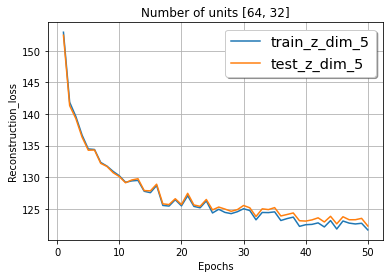

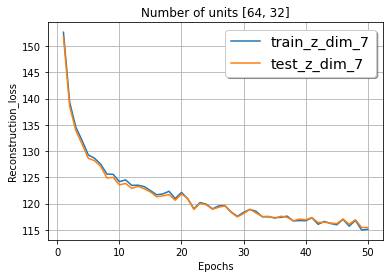

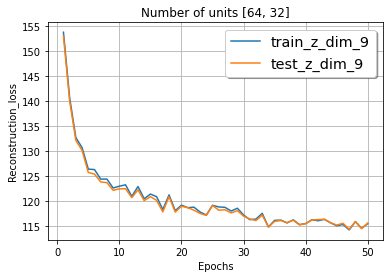

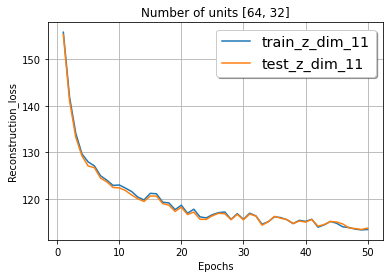

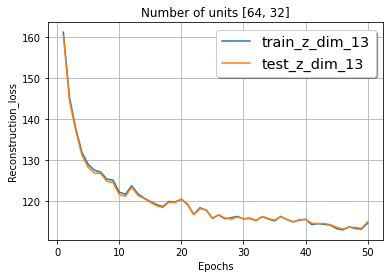

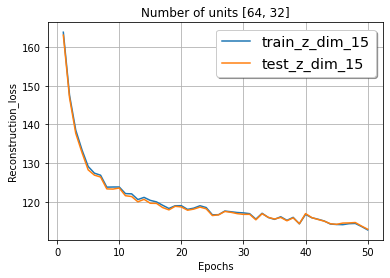

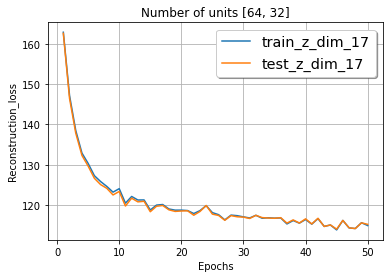

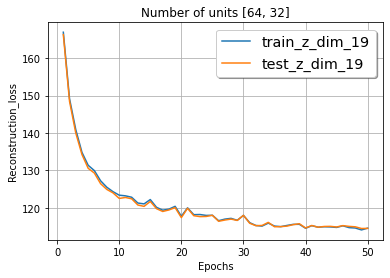

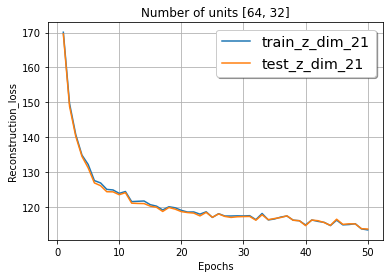

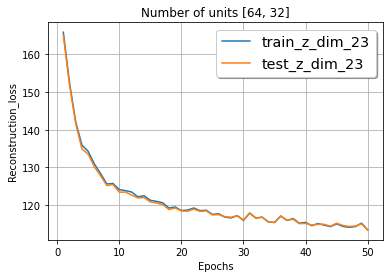

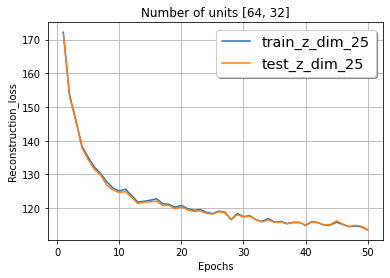

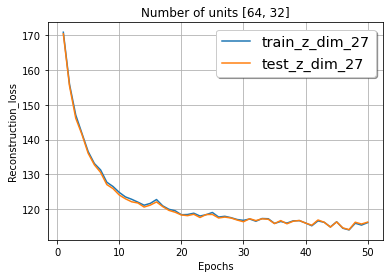

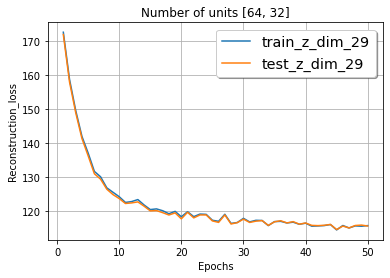

<Figure size 432x288 with 0 Axes>

In [6]:
num_unit_index += 1
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units_list[num_unit_index],
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5,
                           metric="reconstruction_loss"
                          )
    plt.figure()

### z_dim Vs metric

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/con

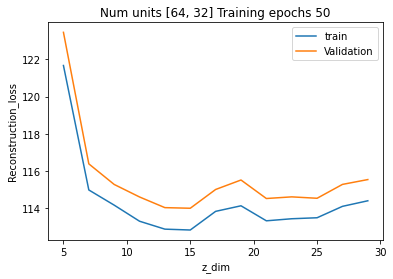

In [7]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


## num_units = [32,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis/reconstruction_loss_0.csv
(50, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_lea

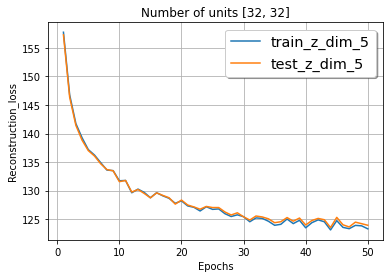

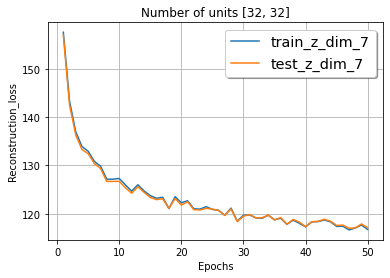

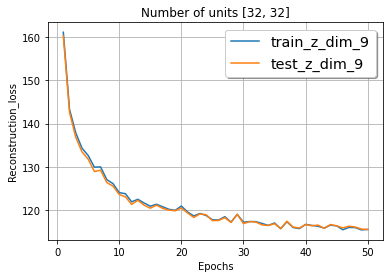

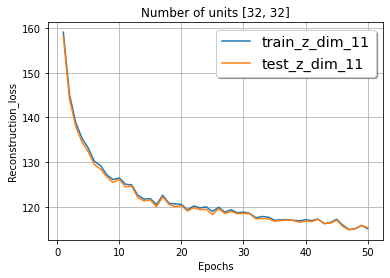

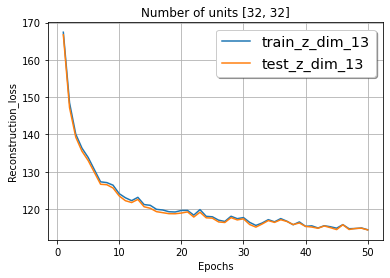

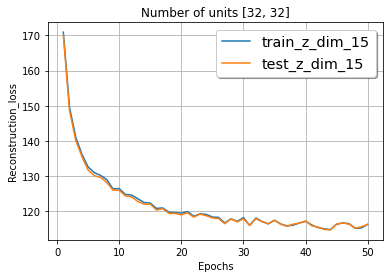

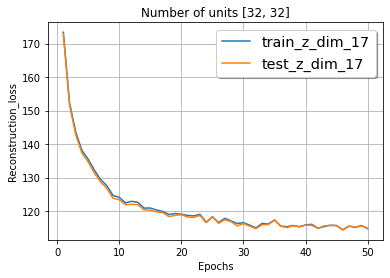

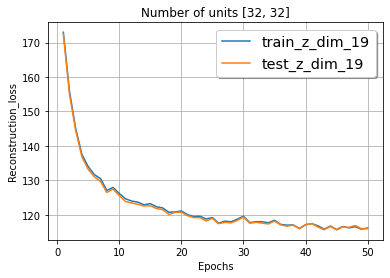

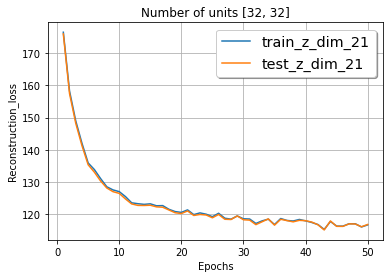

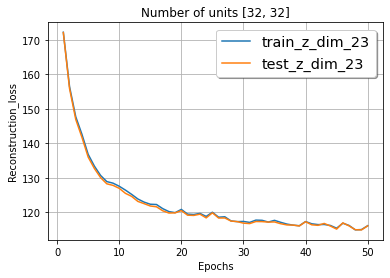

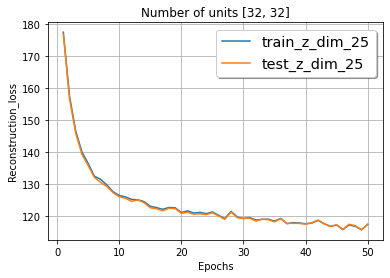

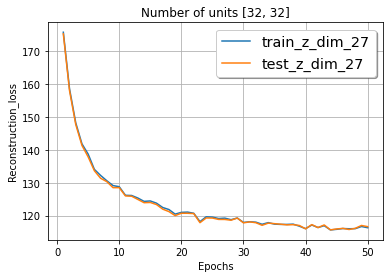

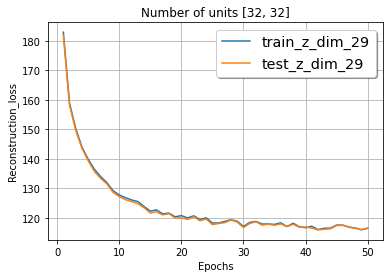

<Figure size 432x288 with 0 Axes>

In [8]:
num_unit_index += 1
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units_list[num_unit_index],
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5,
                           metric="reconstruction_loss"
                          )
    plt.figure()

### Plot z_dim Vs Accuracy

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_32_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/con

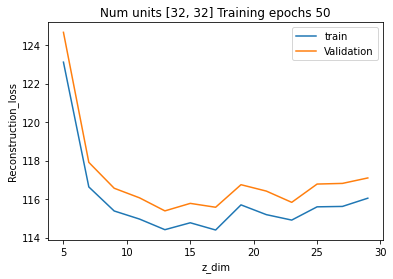

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


## num_units=[16,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis/reconstruction_loss_0.csv
(50, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_lea

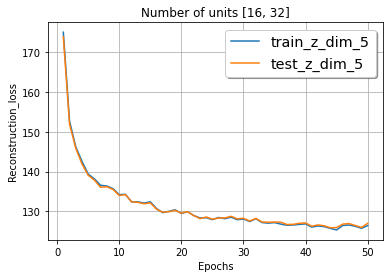

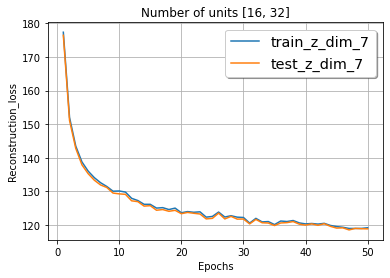

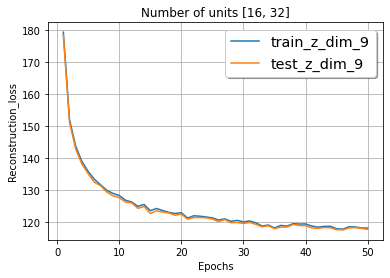

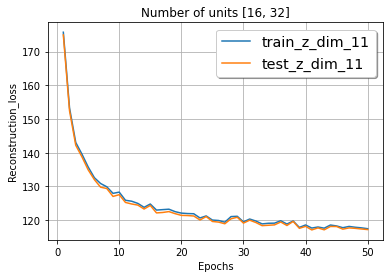

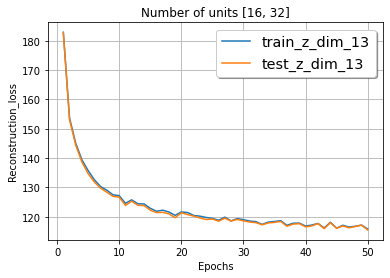

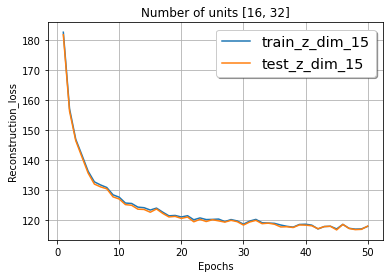

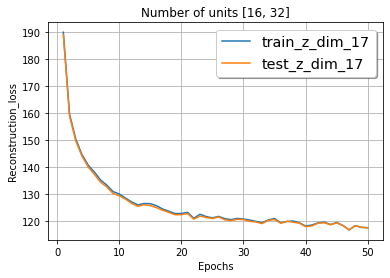

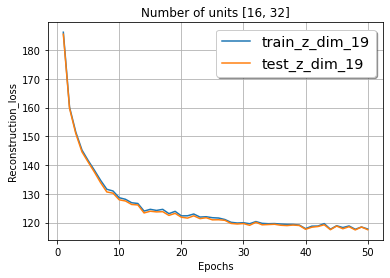

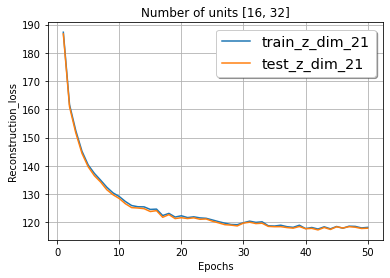

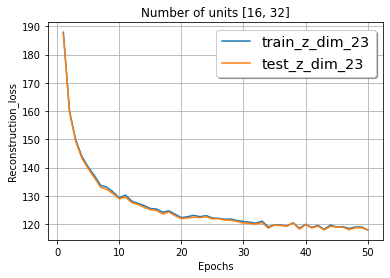

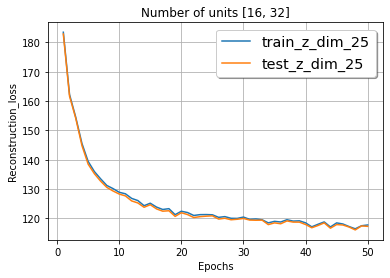

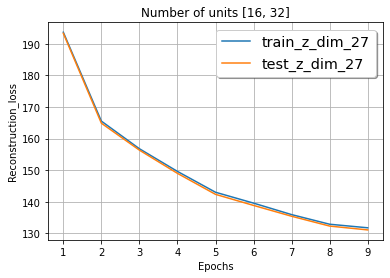

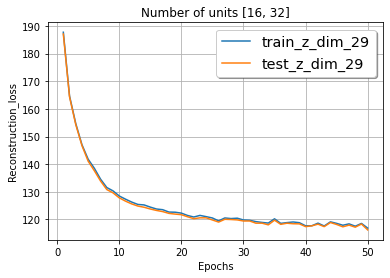

<Figure size 432x288 with 0 Axes>

In [ ]:
num_unit_index += 1
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units_list[num_unit_index],
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5,
                           metric="reconstruction_loss"
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_16_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/con

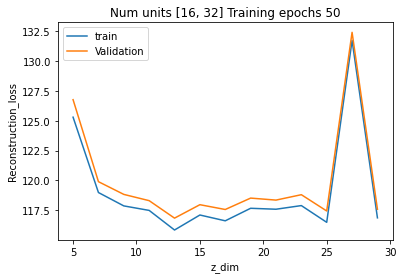

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


## Num Units [8,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_l

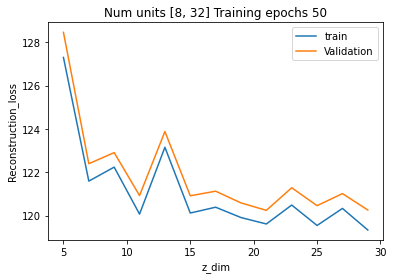

In [ ]:
num_unit_index += 1
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_8_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_l

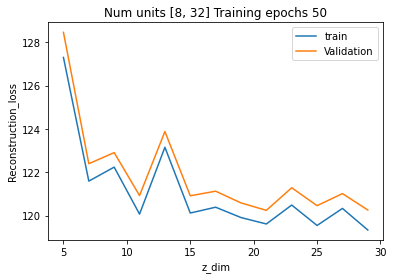

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


## Num units [4, 32]

### Epoch Vs Reconstruction loss

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis/reconstruction_loss_0.csv
(50, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/

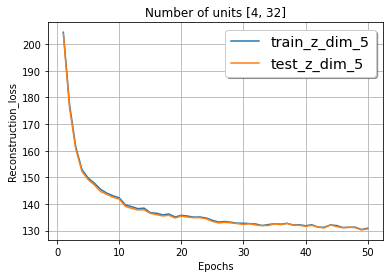

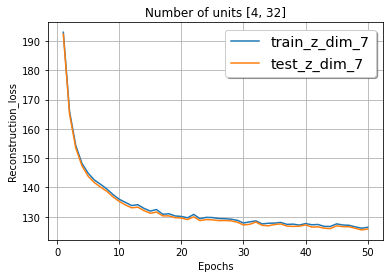

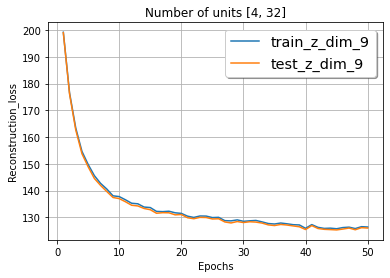

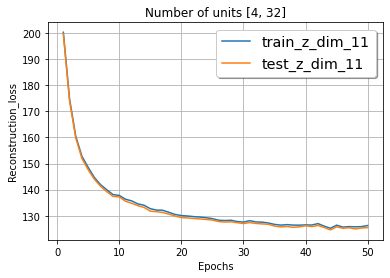

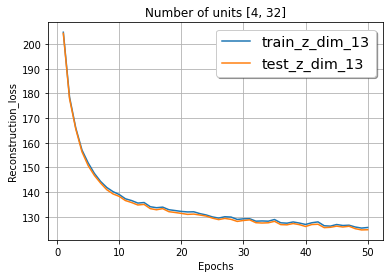

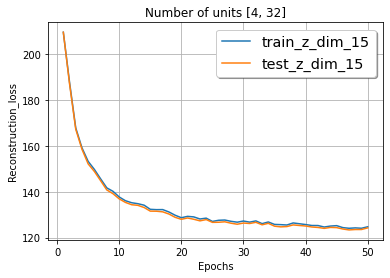

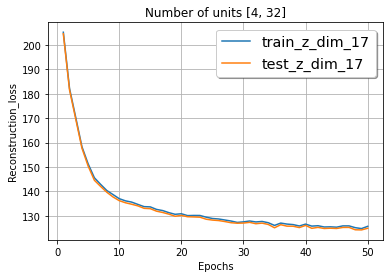

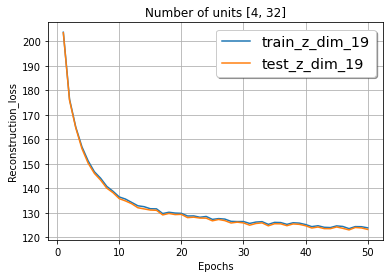

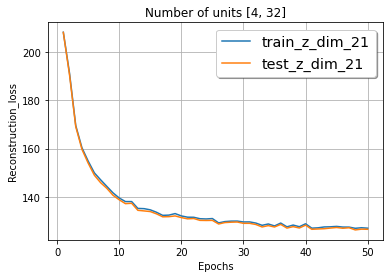

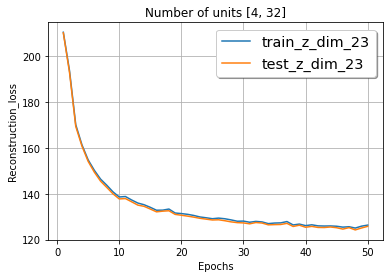

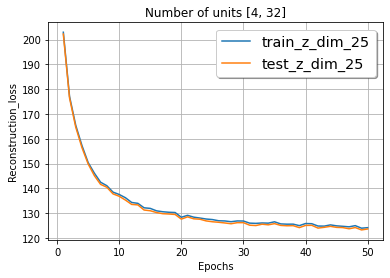

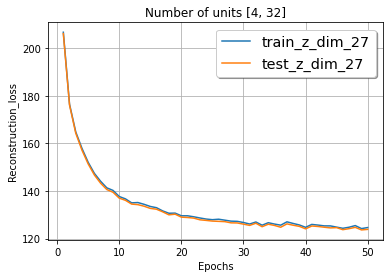

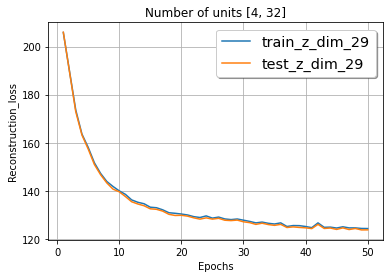

<Figure size 432x288 with 0 Axes>

In [ ]:
num_unit_index += 1
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units_list[num_unit_index],
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5,
                           metric="reconstruction_loss"
                          )
    plt.figure()

### z_dim vs reconstruction loss

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_4_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_l

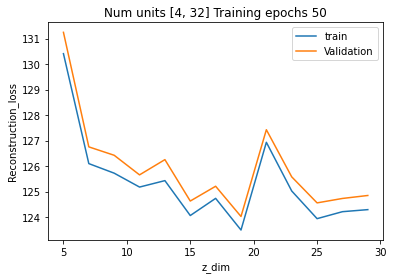

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


## num_units=[2,32]

### Epoch Vs Reconstruction loss

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis/reconstruction_loss_0.csv
(50, 7)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_7_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/

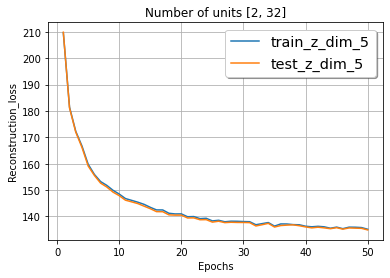

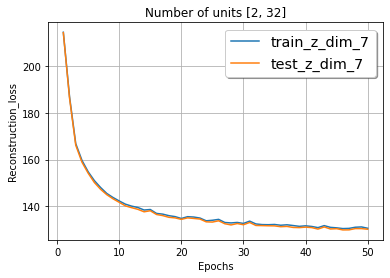

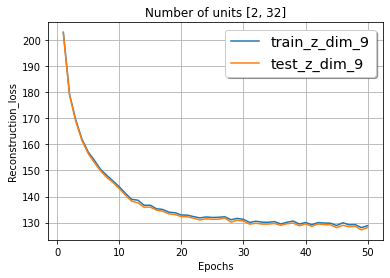

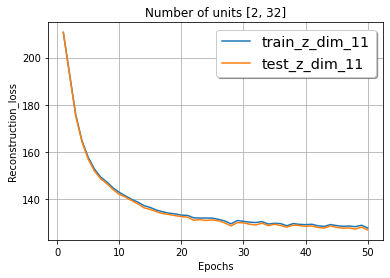

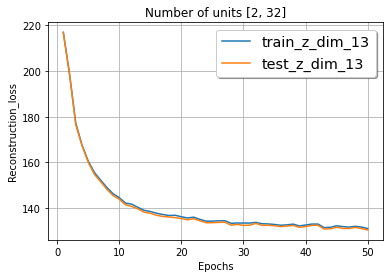

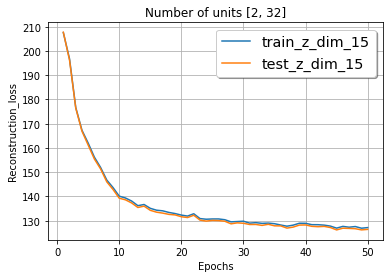

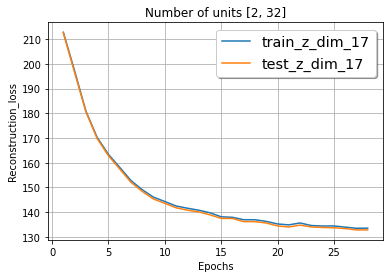

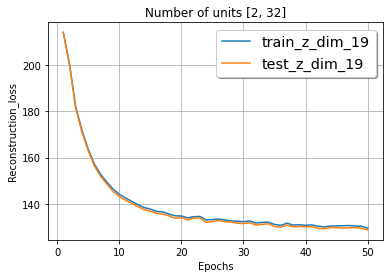

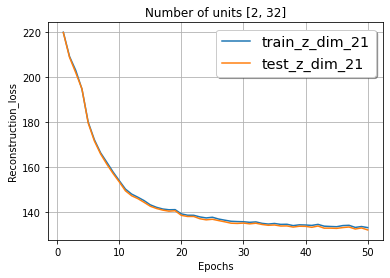

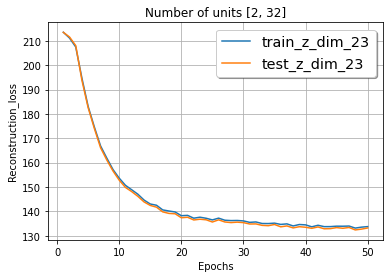

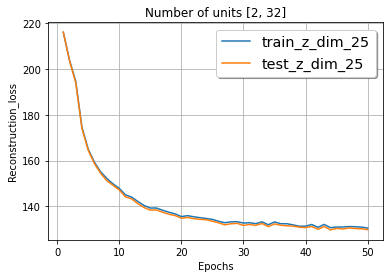

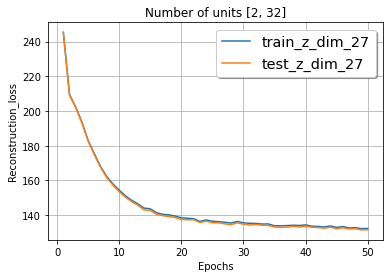

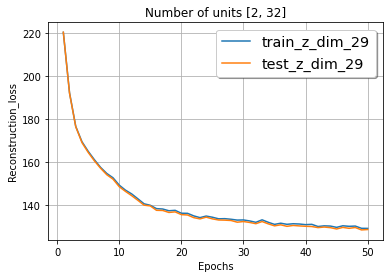

<Figure size 432x288 with 0 Axes>

In [ ]:
num_unit_index += 1
for z_dim in z_dim_range:
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units_list[num_unit_index],
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5,
                           metric="reconstruction_loss"
                          )
    plt.figure()

### z_dim vs reconstruction loss

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//train_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis/reconstruction_loss_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//val_reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_5_1/analysis//reconstruction_loss_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_l

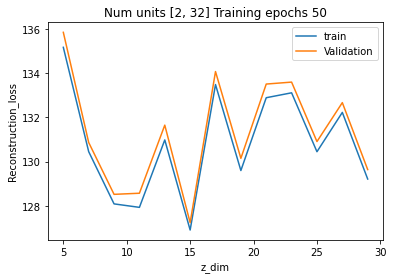

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                       experiment_name=experiment_name,
                       z_dim_range=z_dim_range,
                num_units=num_units_list[num_unit_index],
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                       metric="reconstruction_loss",
                       cumulative_function=np.min
                )


# Scatter plot 

In [13]:
def plot_hidden_units_accuracy_layerwise(root_path: str,
                                         experiment_name: str,
                                         num_units: List[List[int]],
                                         num_cluster_config: str,
                                         z_dim: int,
                                         run_id: int,
                                         dataset_types: List[str] = ["train", "test"],
                                         dataset_name="mnist",
                                         split_name="Split_1",
                                         batch_size=64,
                                         num_val_samples=128,
                                         num_decoder_layer=4,
                                         layer_num=0,
                                         fixed_layers=[],
                                         metric="accuracy",
                                         cumulative_function="max",
                                         fig_size=(20,8),
                                         fname=None
                                         ):
    if cumulative_function == "max":
        function_to_cumulate = np.max
        arg_function = np.argmax
    elif cumulative_function == "min":
        function_to_cumulate = np.min
        arg_function = np.argmin
    else:
        raise Exception("Argument cumulative function should be either min or max")
    dao = get_dao(dataset_name, split_name, num_val_samples)
    for dataset_name in dataset_types:
        plt.figure(figsize=fig_size)

        plt.xlabel("Hidden Units")
        plt.ylabel(f"Max {metric.capitalize()}({dataset_name})")
        accuracies = dict()
        num_epochs_trained = -1
        for num_unit in num_units:
            if len(fixed_layers) > 0:
                skip_this = False
                for index, fixed_layer in enumerate(fixed_layers):
                    if num_unit[index] != fixed_layer:
                        skip_this = True
                        break
                if skip_this:
                    print(f"Skipping num_units {num_unit}")
                    continue

            exp_config = ExperimentConfig(root_path=root_path,
                                          num_decoder_layer=num_decoder_layer,
                                          z_dim=z_dim,
                                          num_units=num_unit,
                                          num_cluster_config=num_cluster_config,
                                          confidence_decay_factor=5,
                                          beta=5,
                                          supervise_weight=1,
                                          dataset_name=dataset_name,
                                          split_name=split_name,
                                          model_name="VAE",
                                          batch_size=batch_size,
                                          name=experiment_name,
                                          num_val_samples=num_val_samples,
                                          total_training_samples=dao.number_of_training_samples,
                                          manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                          reconstruction_weight=1,
                                          activation_hidden_layer="RELU"
                                          )
            exp_config.check_and_create_directories(run_id, False)

            file_prefix = f"/{metric}*.csv"
            df = read_accuracy_from_file(exp_config.ANALYSIS_PATH + file_prefix)
            metric_col_name = f"{dataset_name}_{metric}_mean"
            if metric_col_name not in df.columns:
                metric_col_name = f"{dataset_name}_{metric}"

            metric_values = df[metric_col_name].values
            if num_unit[layer_num] in accuracies:
                accuracies[num_unit[layer_num]].append([sum(num_unit[layer_num + 1:]),
                                                        float(function_to_cumulate( metric_values)),
                                                        int(arg_function(metric_values))
                                                        ]
                                                       )
            else:
                accuracies[num_unit[layer_num]] = [[sum(num_unit[layer_num + 1:]),
                                                    float(function_to_cumulate(metric_values)),
                                                    int(arg_function(metric_values))
                                                    ]
                                                   ]
            _num_epochs_trained = df["epoch"].max() + 1
            if num_epochs_trained == -1:
                num_epochs_trained = _num_epochs_trained
            else:
                if _num_epochs_trained != num_epochs_trained:
                    print(f"Number of epochs for {num_unit} is {_num_epochs_trained}")

        for layer_0_units in accuracies.keys():
            x_y = np.asarray(accuracies[layer_0_units])
            sns.scatterplot(x_y[:, 0], x_y[:, 1], label=f"Units in layer {layer_num} {layer_0_units}", s=450)
            sns.lineplot(x_y[:, 0], x_y[:, 1])
        plt.legend(loc='lower right', shadow=True, fontsize='x-large')
        plt.title(f"Number of epochs trained {num_epochs_trained}. Fixed units ={fixed_layers}")
        if fname is not None:
            fname = exp_config.ANALYSIS_PATH + fname
            print(f"Saving plot in file {fname}")
            plt.savefig(fname, bbox="tight")

    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.grid()
    return accuracies

Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_11_1/analysis//reconstruction_loss*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_11_1/analysis//reconstruction_loss*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_64_11_1/analysis/reconstruction_loss_0.csv
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Saving plot in file /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/Exp_0_32_2_11_1/analysis/2_layer_scatter_plot_unsup.pdf
{64: [[32, 113.40843200683594, 48]], 32: [[32, 114.87259674072266, 46]], 16: [[32, 117.1187515258789, 40]], 8: [[32, 119.42201232910156, 45]], 4: [[32, 124.54549407958984, 43]], 2: [[32, 127.10923767089844, 49]]}


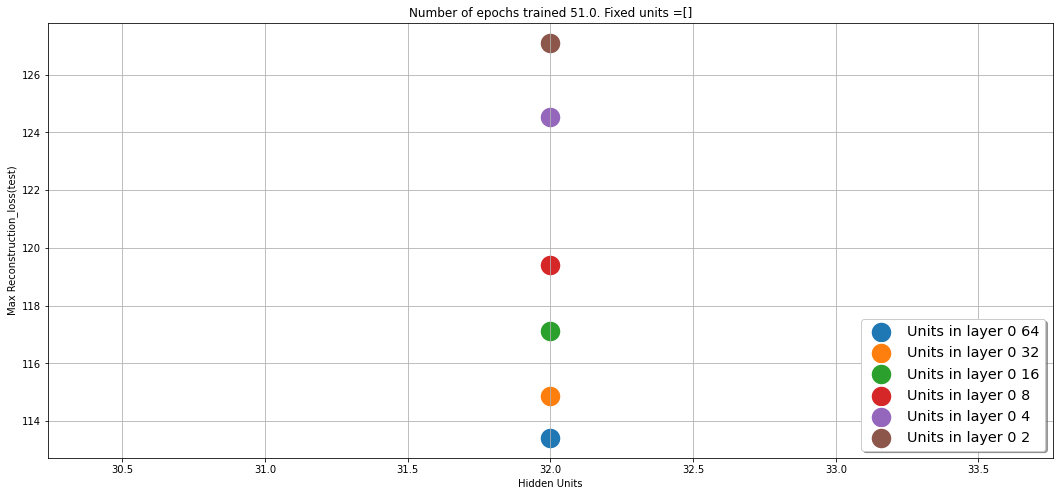

In [15]:
z_dim = 11
accuracies = plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units_list,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=0,
                        fixed_layers=[],
                        dataset_types=["test"],
                        metric=metric,
                        cumulative_function="min",
                        fig_size=(18,8),
                        fname="2_layer_scatter_plot_unsup.pdf"
                      )
print(accuracies)

In [42]:
dao = get_dao(dataset_name, split_name, num_val_samples)

def get_exp_config(num_units, z_dim):
    exp_config = ExperimentConfig(root_path=root_path,
                                  z_dim=z_dim,
                                  num_units=num_units,
                                  num_cluster_config=num_cluster_config,
                                  confidence_decay_factor=5,
                                  beta=5,
                                  supervise_weight=1,
                                  dataset_name=dataset_name,
                                  split_name=split_name,
                                  model_name="VAE",
                                  batch_size=batch_size,
                                  name=experiment_name,
                                  num_val_samples=num_val_samples,
                                  total_training_samples=dao.number_of_training_samples,
                                  manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                  reconstruction_weight=1,
                                  activation_hidden_layer="RELU",
                                  num_decoder_layer=2
                                  )
    return exp_config
num_steps = 328
exp_config = get_exp_config(num_units_list[0], z_dim)
exp_config.check_and_create_directories(run_id, False)

# num_steps = dao.number_of_training_samples // batch_size
dataset_types = ["test", "val", "train"]
reconstructed_dir = get_eval_result_dir(exp_config.PREDICTION_RESULTS_PATH,
                                        1,
                                        num_steps
                                        )

image_path = reconstructed_dir + dataset_types[0] + "_" +  "TOP" + "_" + str(0)+".png"
image = np.squeeze(cv2.imread(image_path))

separator = np.ones( (image.shape[0], 10, image.shape[2]), np.uint8 ) * 255
large_separator = np.ones( (image.shape[0], 30, image.shape[2]), np.uint8 ) * 255

In [53]:
def display_reconstructed_images(exp_config:ExperimentConfig,
                                 images_to_show,
                                 fname:str):
  fixed_layer=[]
  print(fname)
  for units_in_layer_0, x in accuracies.items():
      for _x in x:
        num_units_after_layer_0 = _x[0]
        num_units = fixed_layer + [units_in_layer_0] + [num_units_after_layer_0]
        exp_config = get_exp_config(num_units, z_dim)
        exp_config.check_and_create_directories(run_id, False)
        reconstruction_loss = _x[1]
        min_epoch = _x[2]
        reconstructed_dir = get_eval_result_dir(exp_config.PREDICTION_RESULTS_PATH,
                                                min_epoch,
                                                num_steps
                                                )
        for metrics_value in [images_to_show]:
            fig = plt.figure(figsize=(20, 10))
            plt.axis("off")
            images_for_dataset = dict()
            for dataset_type_name in dataset_types:
                images = [None] * 2
                for i in range(2):
                    image_path = reconstructed_dir + dataset_type_name +"_" +  metrics_value + "_" + str(i)+".png"
                    images[i] = np.squeeze(cv2.imread(image_path))
                combined_image = np.hstack((images[0], separator, images[1]))
                images_for_dataset[dataset_type_name] = combined_image
            
            final_image = images_for_dataset[dataset_types[0]]
            dataset_type_names_str = dataset_types[0]
            for dataset_type_name in dataset_types[1:]:
                final_image = np.hstack((final_image, large_separator, images_for_dataset[dataset_type_name]))
                dataset_type_names_str = dataset_type_names_str + ", " + dataset_type_name
            plt.title(f"Reconstructed images. Number of units in hidden layer {units_in_layer_0}. Datasets {dataset_type_names_str} respectively from left to right. Loss {reconstruction_loss} ")
            plt.imshow(final_image)
            print(fname)
            if fname is not None:
                fqfn = f"{exp_config.root_path}/{experiment_name}/{ str(units_in_layer_0) }_{metrics_value}_{fname}"
                print(f"Saving file at {fqfn}")
                plt.savefig(fname,bbox="tight")


sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/64_TOP_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/32_TOP_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/16_TOP_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/8_TOP_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/4_TOP_sample_reconstructed_images.pdf
sample_reconstructed_imag

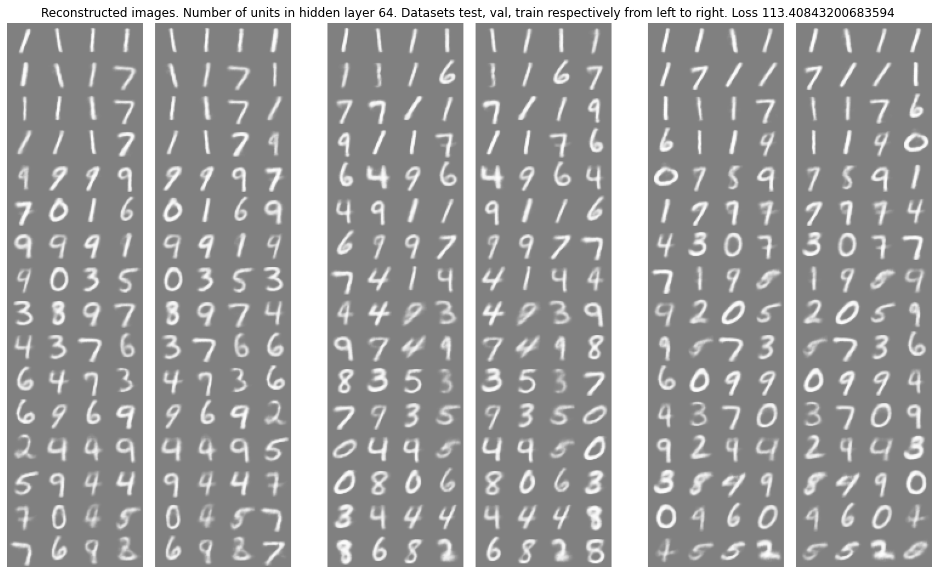

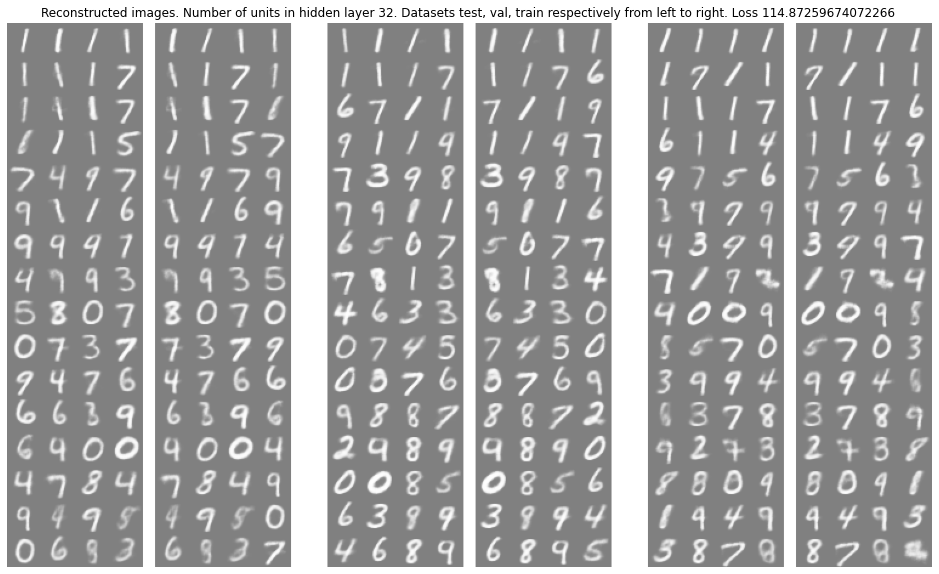

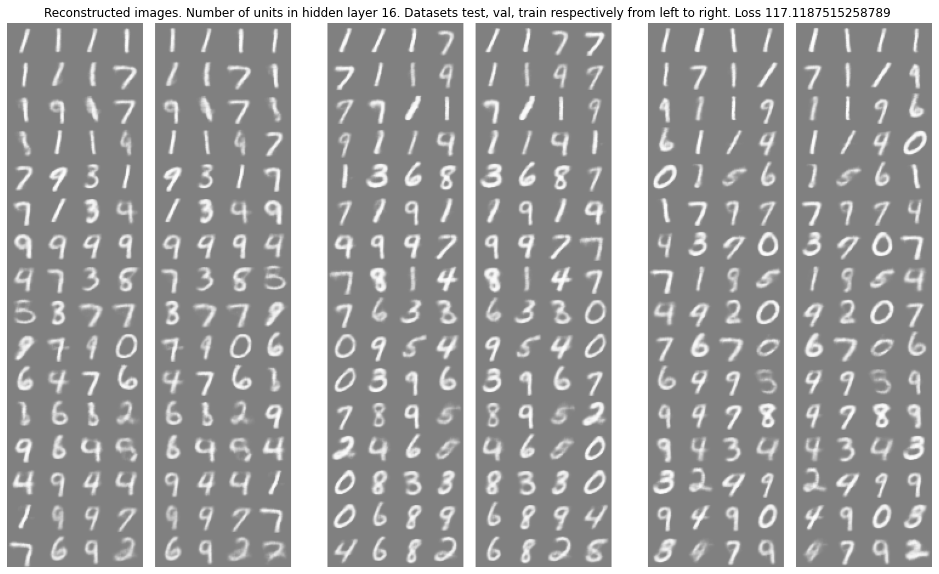

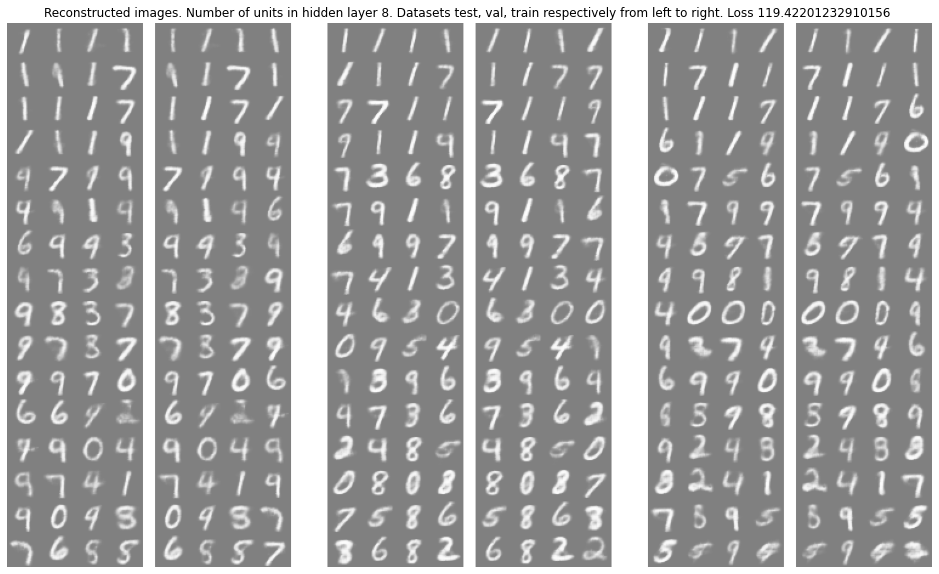

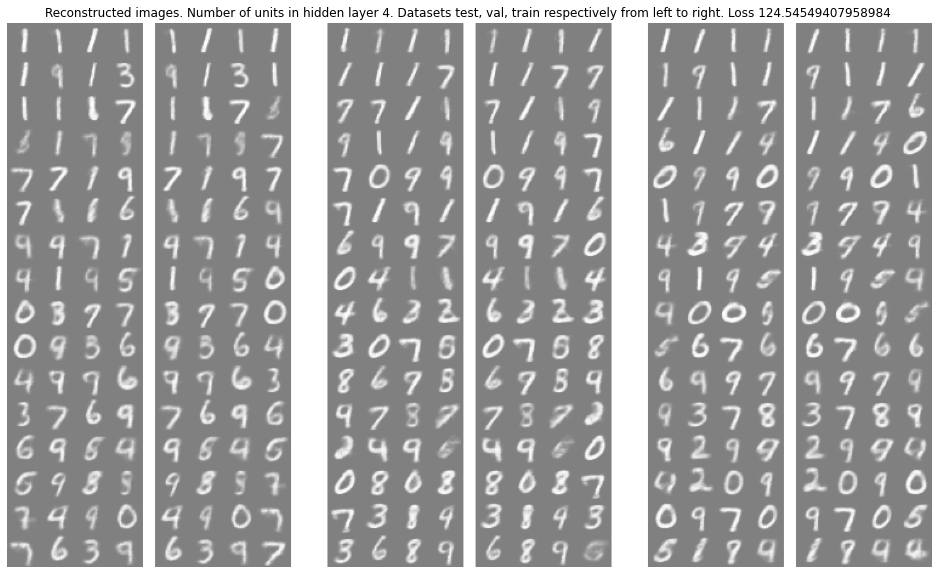

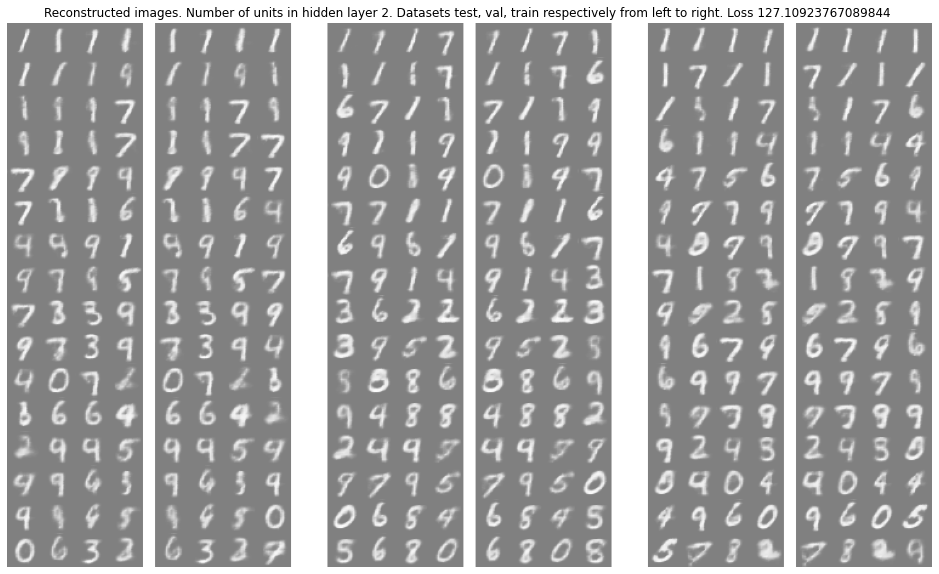

In [56]:
fname = "sample_reconstructed_images.pdf"
display_reconstructed_images(exp_config, "TOP", fname)

sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/64_BOTTOM_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/32_BOTTOM_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/16_BOTTOM_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/8_BOTTOM_sample_reconstructed_images.pdf
sample_reconstructed_images.pdf
Saving file at /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/4_BOTTOM_sample_reconstructed_images.pdf
sample_rec

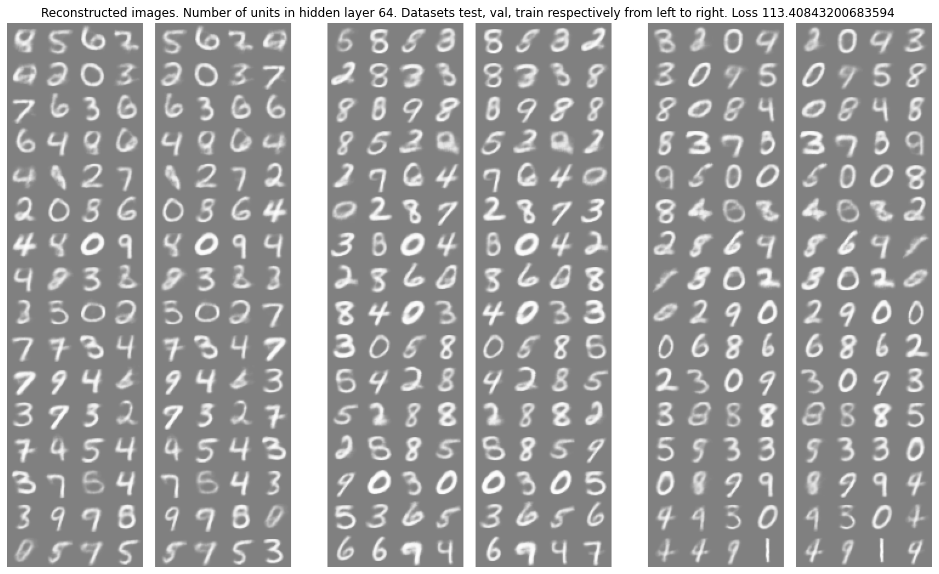

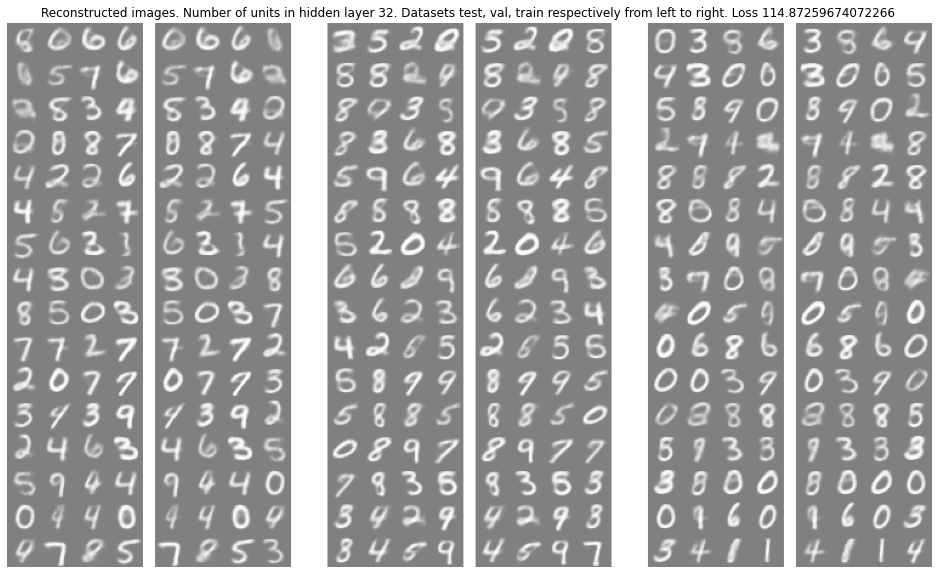

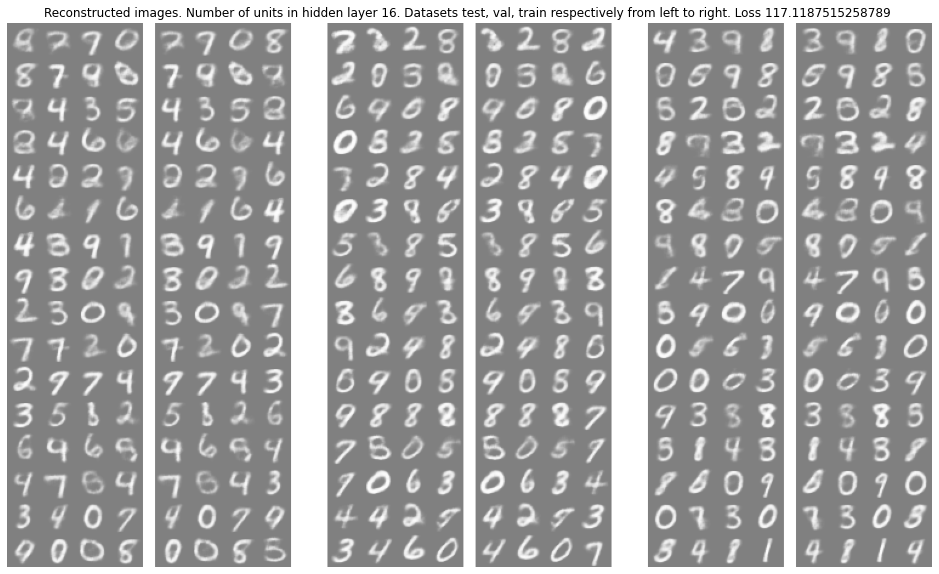

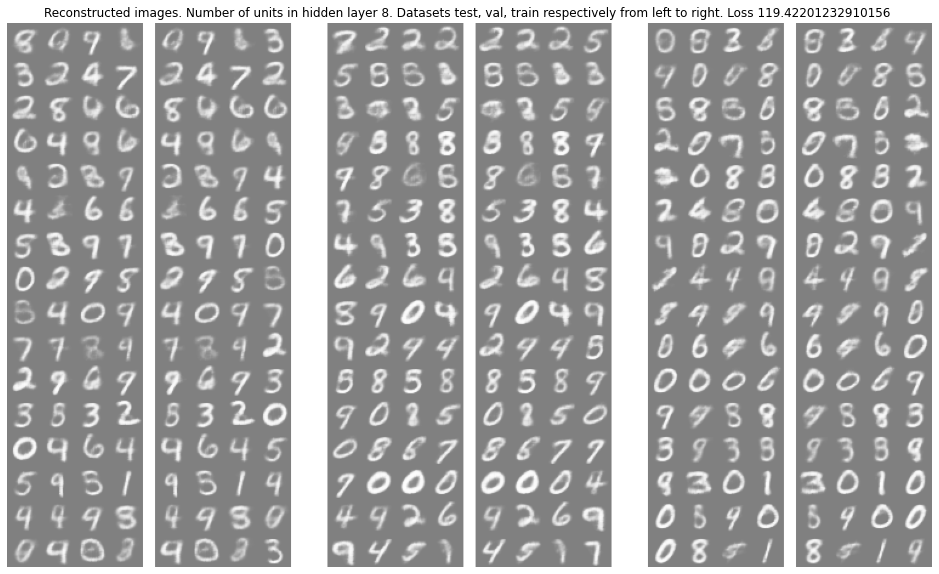

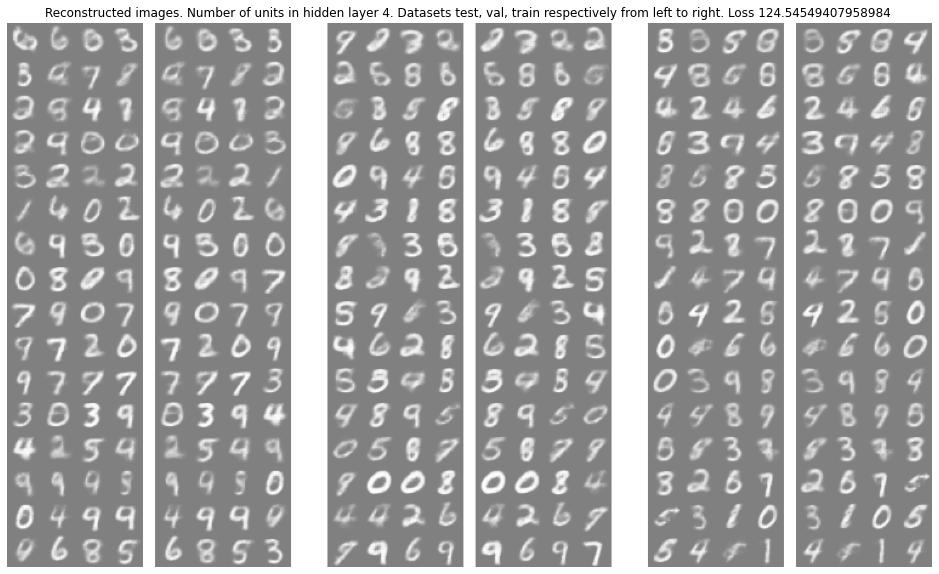

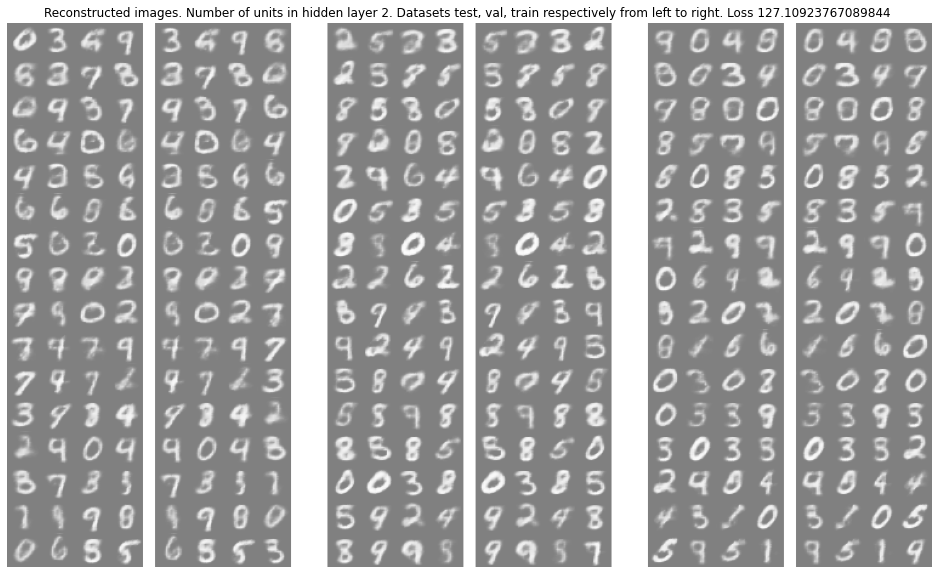

In [57]:
display_reconstructed_images(exp_config, "BOTTOM", fname)

In [58]:
import json
fname = exp_config.root_path+ "/" + experiment_name + "/" + "accuracy_vs_model_complexity.json"
with open(fname, "w") as filep:
  json.dump(accuracies, filep)

In [60]:
!ls -ltr /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/find_architecture_unsup/


total 531
drwx------ 6 root root   4096 Apr  5 14:49 Exp_0_32_64_5_1
drwx------ 6 root root   4096 Apr  5 14:55 Exp_0_32_64_7_1
drwx------ 6 root root   4096 Apr  5 15:02 Exp_0_32_64_9_1
drwx------ 6 root root   4096 Apr  5 15:08 Exp_0_32_64_11_1
drwx------ 6 root root   4096 Apr  5 15:14 Exp_0_32_64_13_1
drwx------ 6 root root   4096 Apr  5 15:20 Exp_0_32_64_15_1
drwx------ 6 root root   4096 Apr  5 15:26 Exp_0_32_64_17_1
drwx------ 6 root root   4096 Apr  5 15:32 Exp_0_32_64_19_1
drwx------ 6 root root   4096 Apr  5 15:39 Exp_0_32_64_21_1
drwx------ 6 root root   4096 Apr  5 15:45 Exp_0_32_64_23_1
drwx------ 6 root root   4096 Apr  5 15:51 Exp_0_32_64_25_1
drwx------ 6 root root   4096 Apr  5 15:57 Exp_0_32_64_27_1
drwx------ 6 root root   4096 Apr  5 16:03 Exp_0_32_64_29_1
drwx------ 6 root root   4096 Apr  5 16:10 Exp_0_32_32_5_1
drwx------ 6 root root   4096 Apr  5 16:15 Exp_0_32_32_7_1
drwx------ 6 root root   4096 Apr  5 16:20 Exp_0_32_32_9_1
drwx------ 6 root root   4096 Apr  5

## num_units = [64,32]

In [ ]:
num_units_list = [[64, 32],
                  [32, 32],
                  [16, 32],
                  [8, 32],
                  [4, 32],
                  [2, 32],
                      ]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_lear

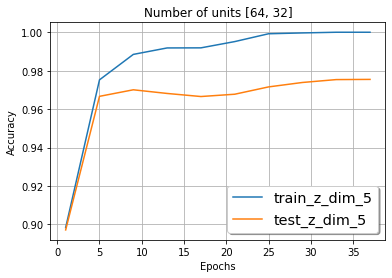

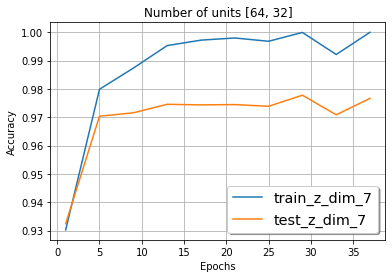

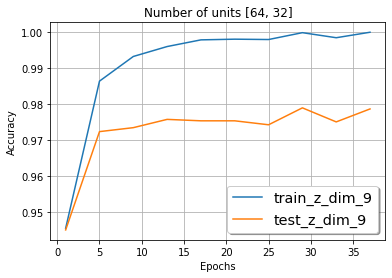

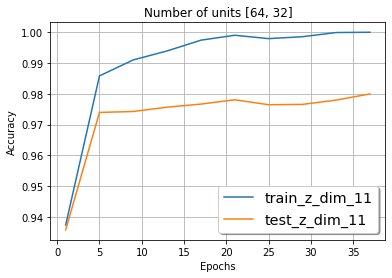

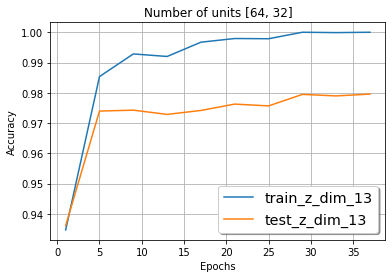

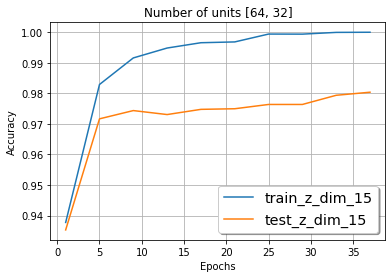

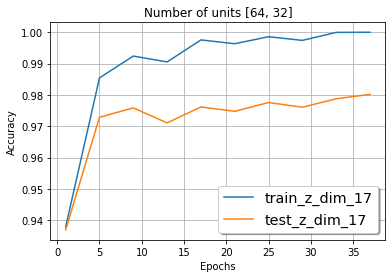

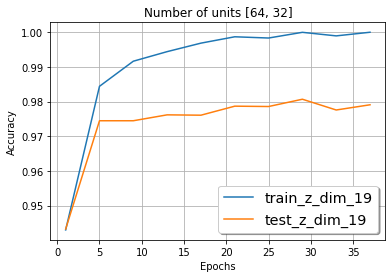

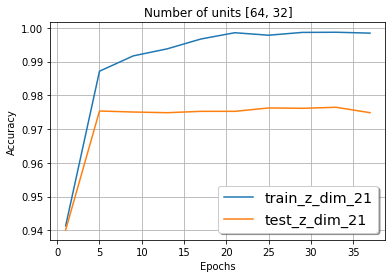

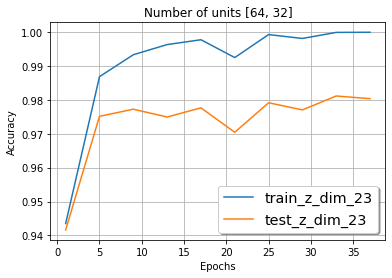

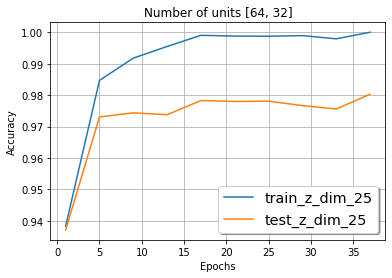

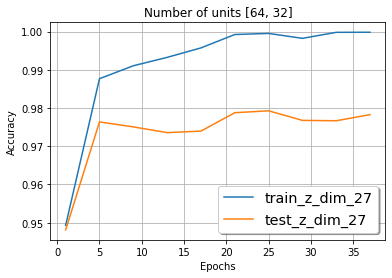

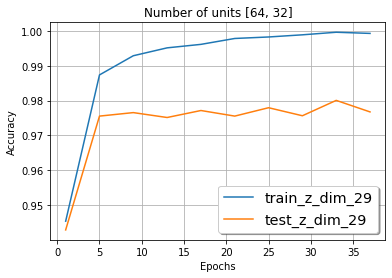

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[0]
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

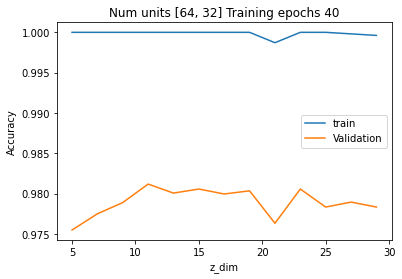

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )


## num_units = [32,32]

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_lear

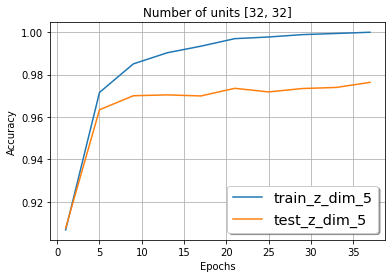

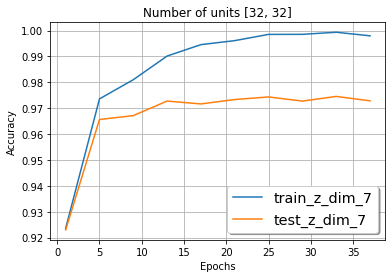

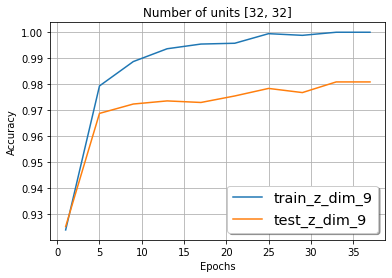

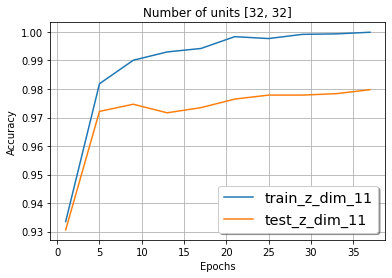

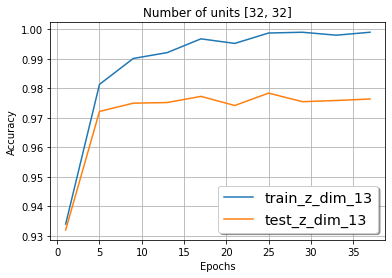

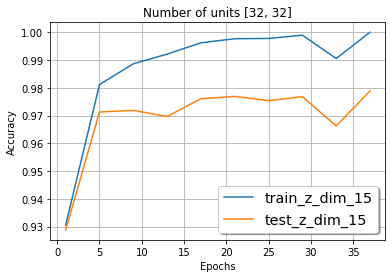

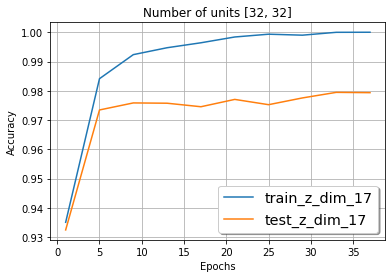

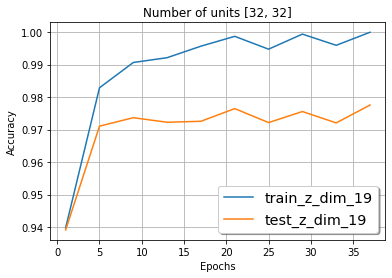

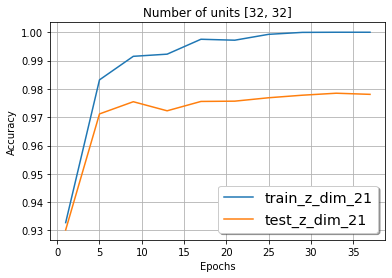

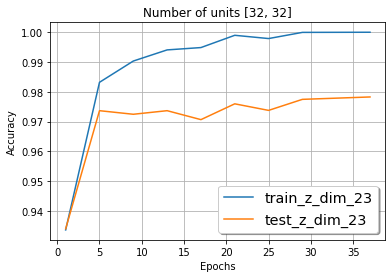

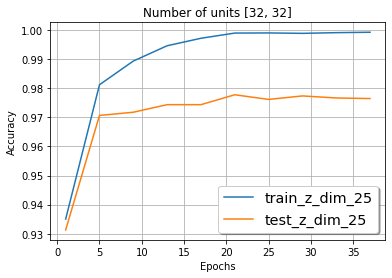

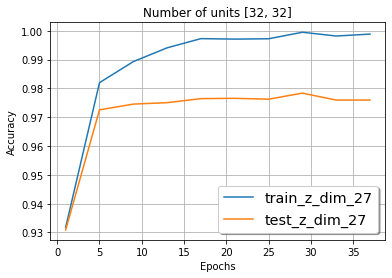

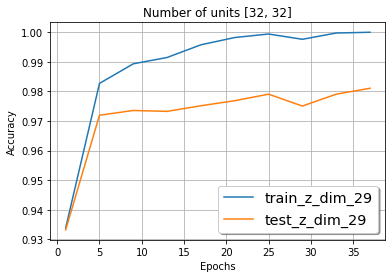

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[1]
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_32_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

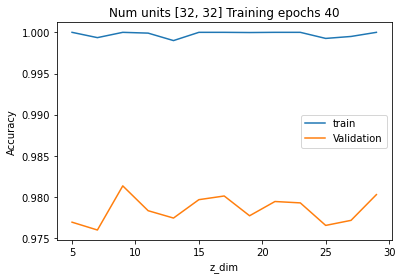

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [16,32]


[16, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/con

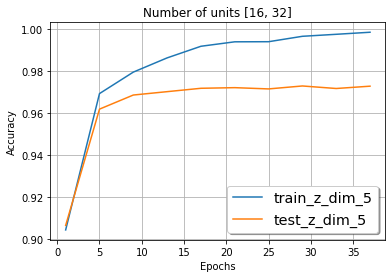

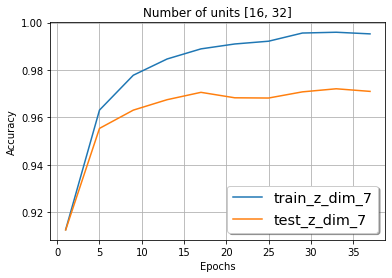

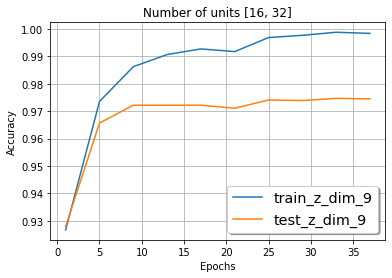

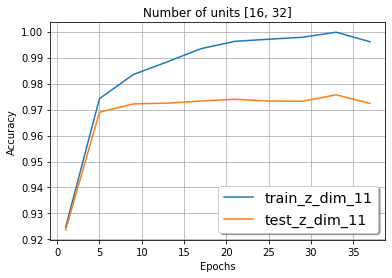

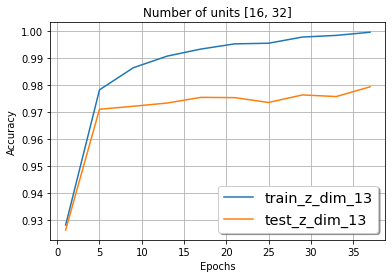

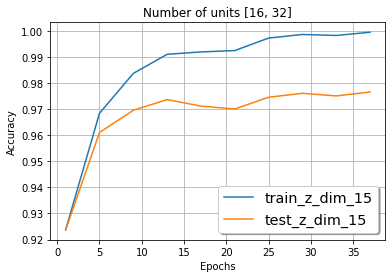

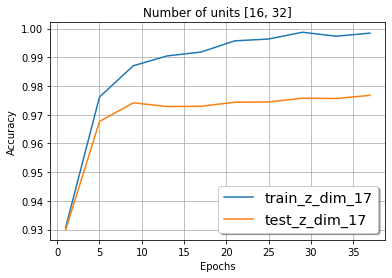

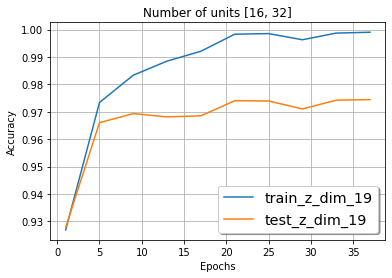

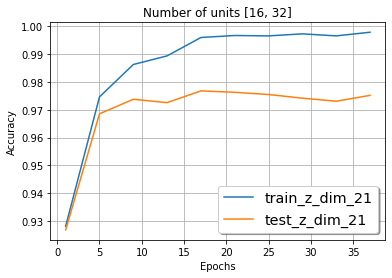

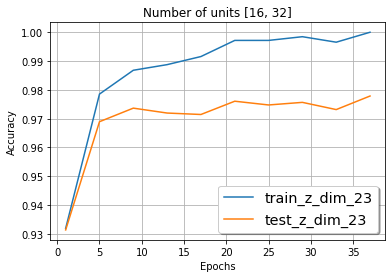

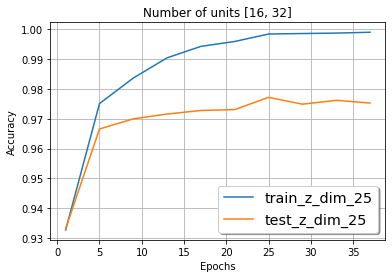

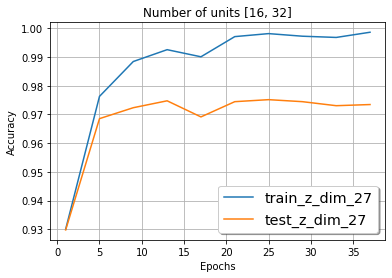

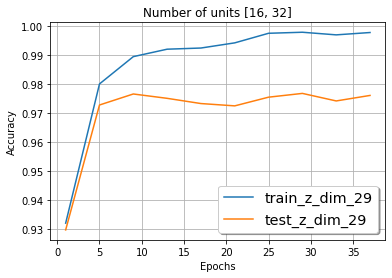

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[2]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_16_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0

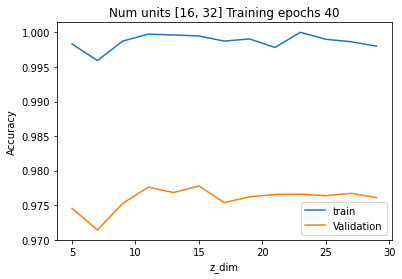

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                num_val_samples=num_val_samples,
                )


## num_units = [8,32]

[8, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

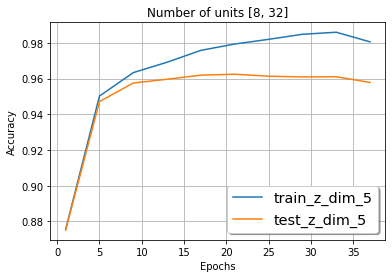

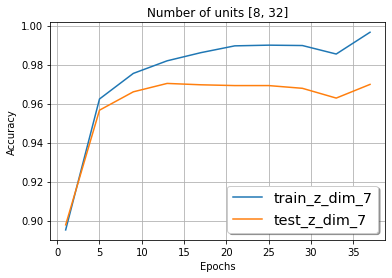

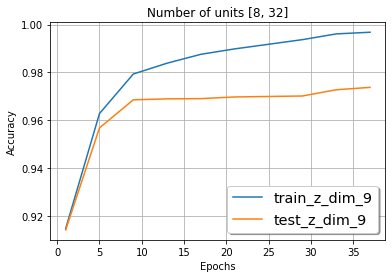

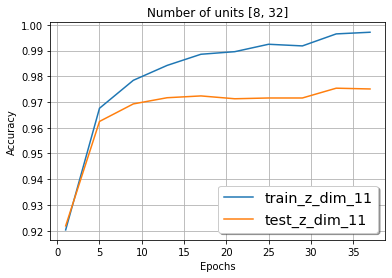

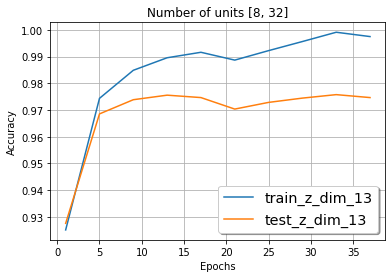

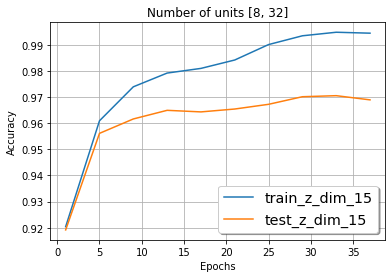

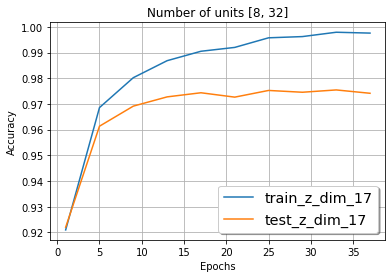

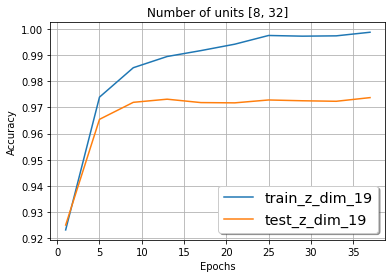

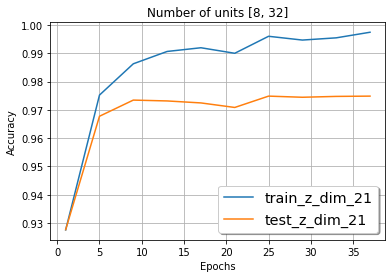

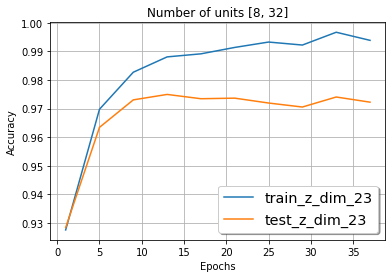

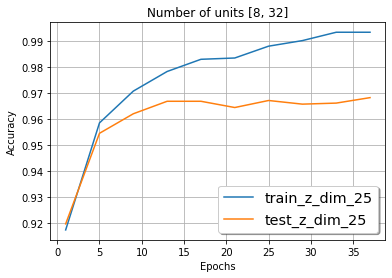

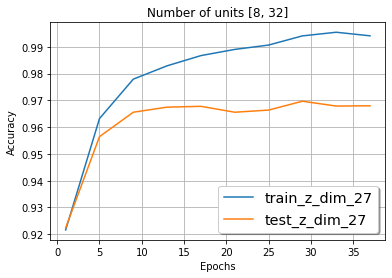

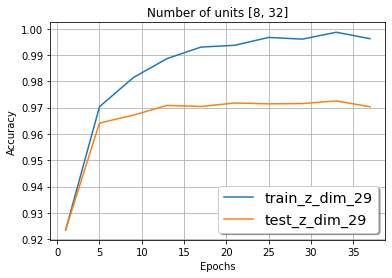

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[3]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_8_

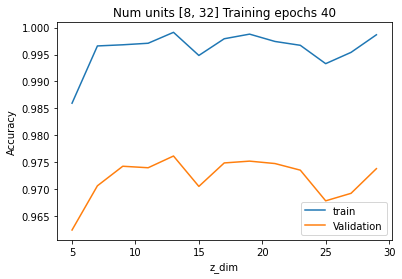

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [4,32]


[4, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

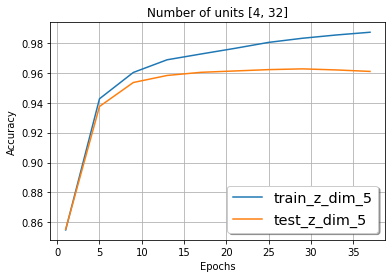

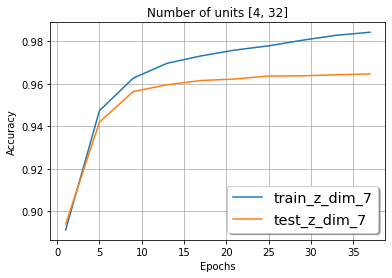

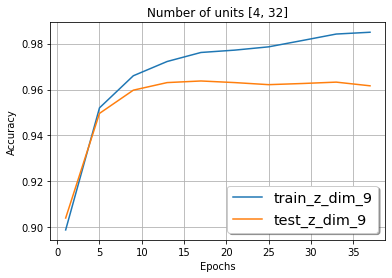

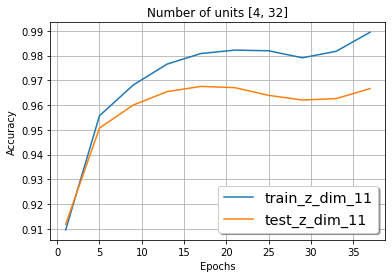

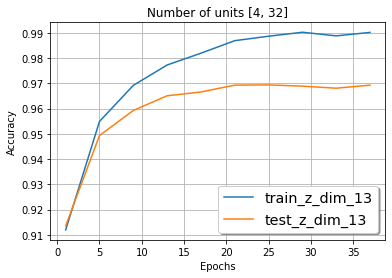

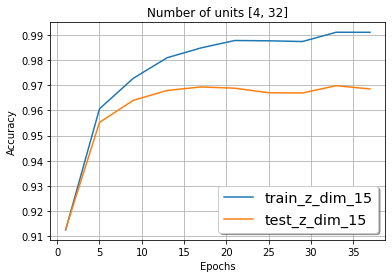

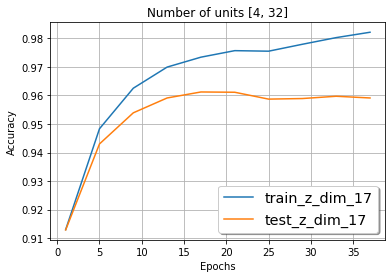

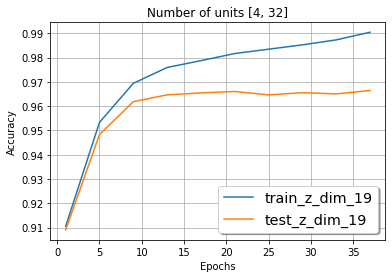

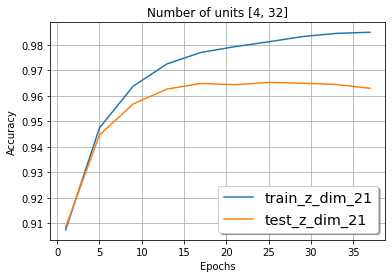

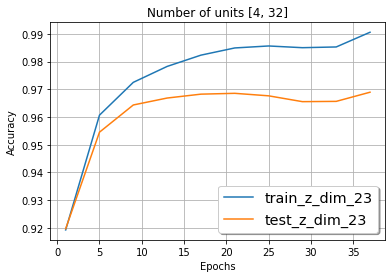

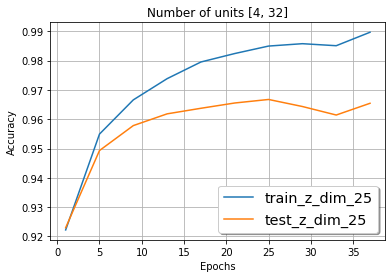

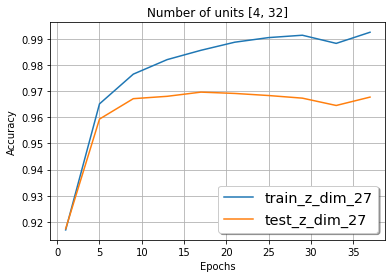

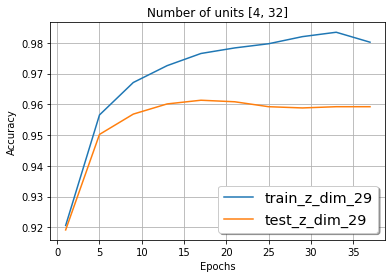

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[4]
print(num_units)
for z_dim in range(5, 30, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_4_

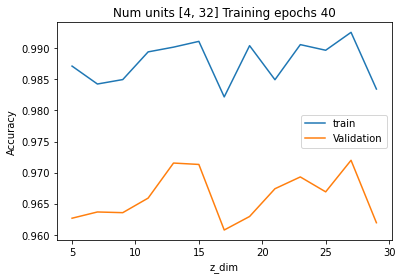

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


## num_units = [2,32]


[2, 32]
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_7_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4)
train
test
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_le

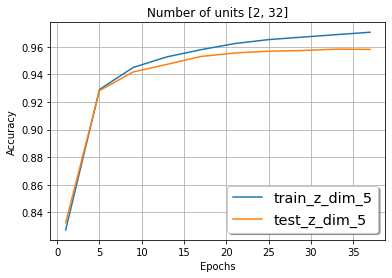

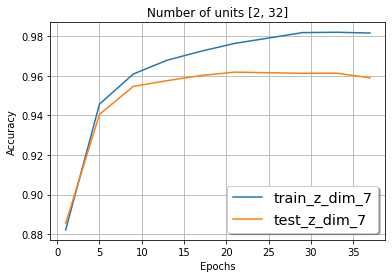

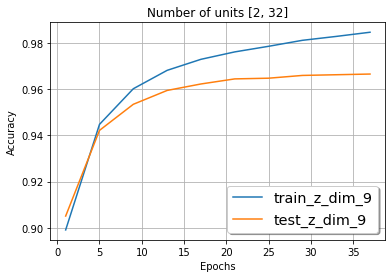

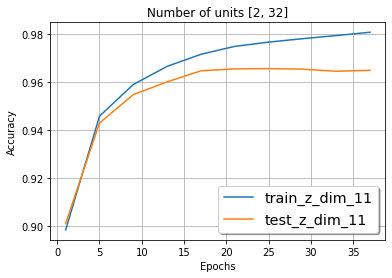

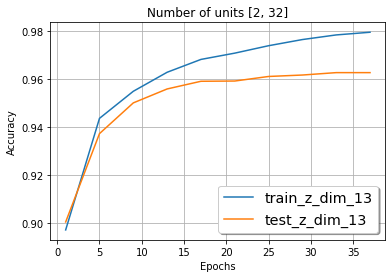

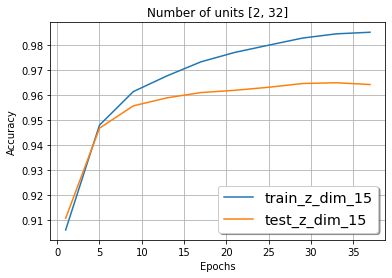

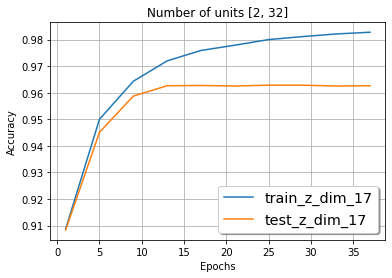

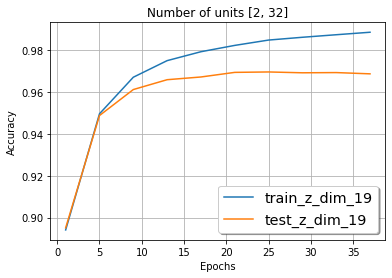

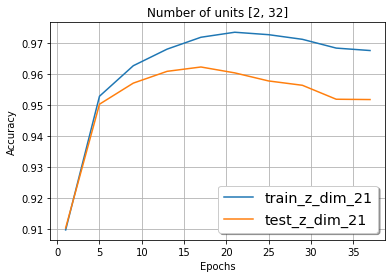

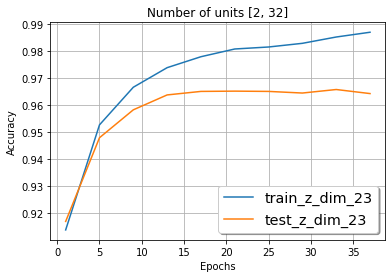

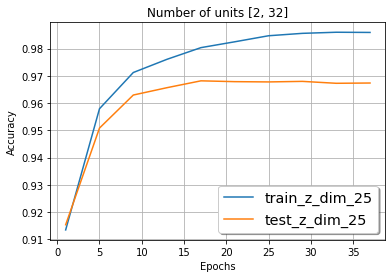

<Figure size 432x288 with 0 Axes>

In [ ]:
num_units = num_units_list[5]
print(num_units)
for z_dim in range(5, 27, 2):
    plot_epoch_vs_accuracy(root_path=root_path,
                           experiment_name=experiment_name,
                           num_units=num_units,
                           num_cluster_config=num_cluster_config,
                           z_dim=z_dim,
                           run_id=run_id,
                           activation_output_layer="LINEAR",
                           dataset_name=dataset_name,
                           split_name=split_name,
                           batch_size=batch_size,
                           num_val_samples=num_val_samples,
                           num_decoder_layer=5
                          )
    plt.figure()

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//train_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//val_accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_5_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_2_

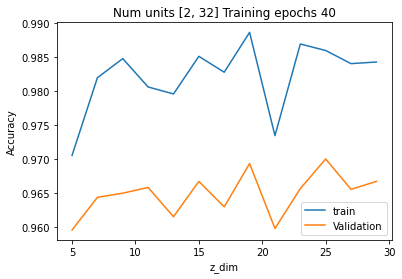

In [ ]:
plot_z_dim_vs_accuracy(root_path=root_path,
                experiment_name=experiment_name,
                z_dim_range=z_dim_range,
                num_units=num_units,
                num_cluster_config=num_cluster_config,
                num_epochs=num_epochs,
                run_id=run_id,
                split_name=split_name,
                               num_val_samples=num_val_samples,
                )


In [ ]:
!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1


In [ ]:
!rm -rf /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1


## Scatter plot

Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis//accuracy_*.csv /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/Experiment_2/Exp_0_32_64_10_TWO_TIMES_ELBOW_1/analysis/accuracy_0.csv
(10, 4) 0.9784655448717948
Missing directories
['/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test', '/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/test/Split_70_30/']
/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learni

{2: [[32, 0.9601362179487181]],
 4: [[32, 0.9725560897435898]],
 8: [[32, 0.9754607371794872]],
 16: [[32, 0.9770633012820512]],
 32: [[32, 0.9778645833333334]],
 64: [[32, 0.9784655448717948]]}

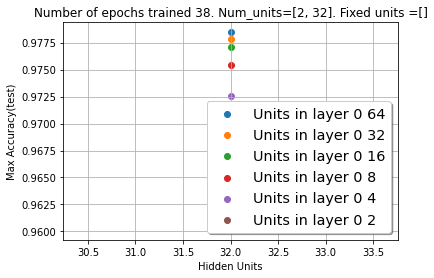

In [ ]:
z_dim = 10
plot_hidden_units_accuracy_layerwise(root_path=root_path,
                        experiment_name=experiment_name,
                        num_units=num_units_list,
                        num_cluster_config=num_cluster_config,
                        z_dim=z_dim,
                        run_id=run_id,
                        activation_output_layer="LINEAR",
                        dataset_name=dataset_name,
                        split_name=split_name,
                        batch_size=batch_size,
                        num_val_samples=num_val_samples,
                        num_decoder_layer=5,
                        layer_num=0,
                        fixed_layers=[],
                        dataset_types=["test"]
                      )